In [1]:
import rasterio
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from patchify import patchify, unpatchify
from osgeo import gdal
from rasterio.plot import show
#import cvnn
#import cvnn.layers as complex_layers <- update tf

In [2]:
os.getcwd()

'/data/private/Thesis/May'

In [3]:
# Set parameters
patch_size = 256
n_bands1 = 2
n_bands2 = 4
n_classes = 2
batch_size = 10

In [4]:
#model = tf.keras.models.load_model("Output/S1/model_s1.h5")
model = tf.keras.models.load_model("Model/slf_m_5e-6/modelfuslate.43-0.20.h5")

2023-05-21 23:21:27.676736: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


In [5]:
# Load image
with rasterio.open("Data/05_River/s1_2022.tif") as src:
    s1 = src.read()
with rasterio.open("Data/05_River/s2_2022.tif") as src:
    s2 = src.read()

In [6]:
s1 = s1/255
s2 = s2/255

In [7]:
s1 = np.transpose(s1, (1,2,0))
s2 = np.transpose(s2, (1,2,0))
print(s2.shape)
print(s1.shape)

(18106, 12495, 4)
(18106, 12495, 2)


**Apply by function from practical**

In [8]:
def pad_image_to_patch_size(image, patch_size=patch_size):
    height, width, depth = image.shape
    target_height = patch_size * int(height // patch_size + 1)
    target_width = patch_size * int(width // patch_size + 1)
    pad_height = (target_height - height) // 2
    pad_width = (target_width - width) // 2
    padded = np.zeros((target_height, target_width, depth))
    padded[pad_height:pad_height + height, pad_width:pad_width + width, :] = image
    return padded, (pad_height, pad_width)

In [9]:
def apply_segmentation_with_fcn2(image1, image2, fcn, patch_size=patch_size, step=patch_size//2):
    original_height1, original_width1, _ = image1.shape
    original_height2, original_width2, _ = image2.shape
    
    # pad the images to patch size
    padded1, (pad_height1, pad_width1) = pad_image_to_patch_size(image1, patch_size)
    padded2, (pad_height2, pad_width2) = pad_image_to_patch_size(image2, patch_size)
    
    height1, width1, _ = padded1.shape
    height2, width2, _ = padded2.shape
    
    predictions1 = np.zeros((height1, width1, n_classes))
    predictions2 = np.zeros((height2, width2, n_classes))
    
    row = 0
    while row + patch_size <= height1 and row + patch_size <= height2:
        row_patches1 = []
        row_patches2 = []

        col = 0 
        while col + patch_size <= width1 and col + patch_size <= width2:
            patch1 = padded1[row:row + patch_size, col:col + patch_size, :]
            patch2 = padded2[row:row + patch_size, col:col + patch_size, :]
            row_patches1.append(patch1)
            row_patches2.append(patch2)
            col += step

        batch1 = np.array(row_patches1)
        batch2 = np.array(row_patches2)
        row_predictions1 = fcn.predict([batch1,batch2], verbose=0)
        #row_predictions2 = fcn.predict(batch2, verbose=0)

        col, patch_idx = 0, 0
        while col + patch_size <= width1 and col + patch_size <= width2:
            predictions1[row:row + patch_size, col:col + patch_size, :] += \
                row_predictions1[patch_idx]
            #predictions2[row:row + patch_size, col:col + patch_size, :] += \
            #    row_predictions2[patch_idx]
            col += step
            patch_idx += 1

        row += step

    predictions1 = predictions1[
        pad_height1:pad_height1 + original_height1,
        pad_width1:pad_width1 + original_width1, :
    ]
    predictions1 = np.argmax(predictions1, axis=-1)
    
    #predictions2 = predictions2[
    #    pad_height2:pad_height2 + original_height2,
    #    pad_width2:pad_width2 + original_width2, :
    #]
    #predictions2 = np.argmax(predictions2, axis=-1)
    
    return predictions1#, predictions2

In [10]:
# Classify image
prediction = apply_segmentation_with_fcn2(s1, s2, model)

## **Visualization and Export**

In [ ]:
s1 = np.transpose(s1, (2,0,1))
s2 = np.transpose(s1, (2,0,1))
print(s1.shape)

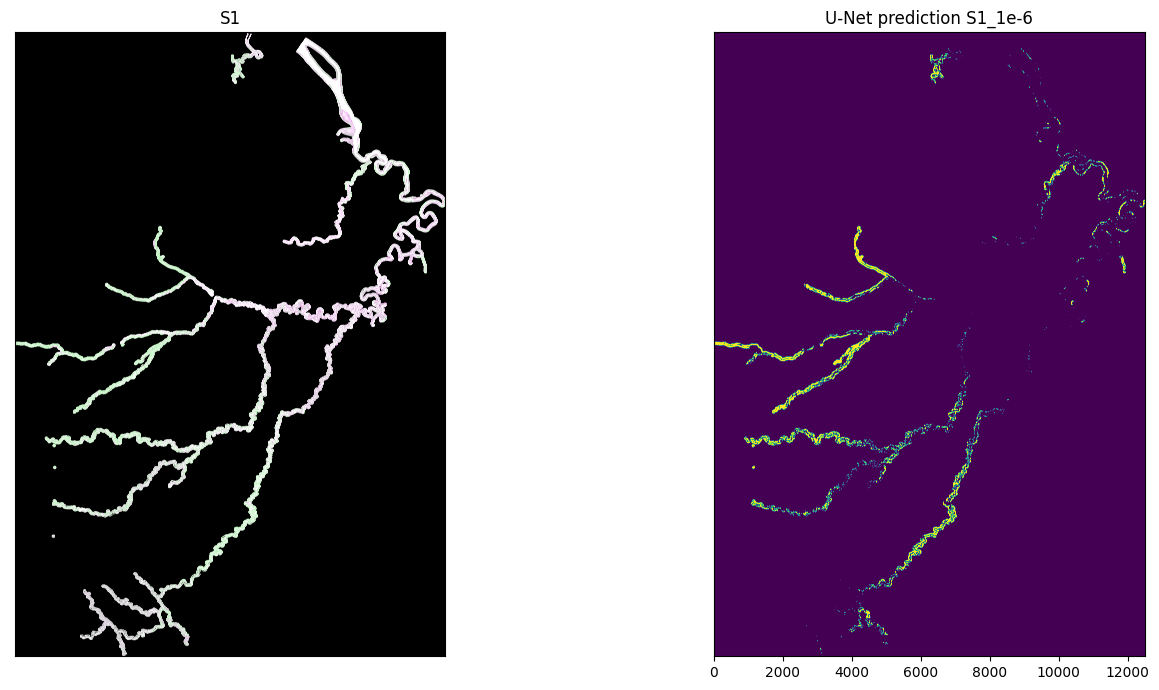

In [13]:
#Plot
import earthpy.plot as ep

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 7), sharey=True)

axs[0] = ep.plot_rgb(s1, rgb=(0, 1, 0), ax=axs[0], stretch=True, title="S1",)
#axs[0].imshow(s2_img[:, :, [2, 1, 0]])
#axs[0].set_title("Satellite image")
axs[1].imshow(prediction)
axs[1].set_title("U-Net prediction S1_1e-6")

plt.tight_layout()
plt.show()

In [19]:
#ras_meta

{'driver': 'GTiff', 'dtype': 'int8', 'nodata': -3.4e+38, 'width': 11570, 'height': 11460, 'count': 1, 'crs': CRS.from_epsg(32647), 'transform': Affine(10.0, 0.0, 619500.0,
       0.0, -10.0, 209600.0), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}

In [11]:
# Export
with rasterio.open("Data/05_River/s1_2022.tif") as src:
    ras_data = src.read()
    ras_meta = src.profile

# make any necessary changes to raster properties, e.g.:
ras_meta['dtype'] = "int8"
ras_meta['nodata'] = -99

with rasterio.open('Output/river_2022.tif', 'w', **ras_meta) as dst:
    dst.write(prediction, 1)

In [12]:
pred = gdal.Open('Output/river_2022.tif')
pred = gdal.Warp("Output/river_2022.tif", pred, cutlineDSName = "Data/04_Validation/Buffer_100.shp",
                  cropToCutline = True, dstNodata = np.nan)
pred = pred.GetRasterBand(1).ReadAsArray()

Warning 1: for band 1, destination nodata value has been rounded to 0, Byte being an integer datatype.


In [23]:
labels, count = np.unique(pred[:,:], return_counts=True)
print("Labels 2019 are: ", labels, " and the counts are: ", count)

Labels 2019 are:  [0 1]  and the counts are:  [223068001    663911]


In [30]:
labels, count = np.unique(pred[:,:], return_counts=True)
print("Labels 2017 are: ", labels, " and the counts are: ", count)

Labels 2017 are:  [0 1]  and the counts are:  [223636499     95413]


In [37]:
labels, count = np.unique(pred[:,:], return_counts=True)
print("Labels 2018 are: ", labels, " and the counts are: ", count)

Labels 2018 are:  [0 1]  and the counts are:  [223132416    599496]


In [44]:
labels, count = np.unique(pred[:,:], return_counts=True)
print("Labels 2020 are: ", labels, " and the counts are: ", count)

Labels 2020 are:  [0 1]  and the counts are:  [222970627    761285]


In [14]:
labels, count = np.unique(pred[:,:], return_counts=True)
print("Labels 2021 are: ", labels, " and the counts are: ", count)

Labels 2021 are:  [0 1]  and the counts are:  [222881909    850003]


In [13]:
labels, count = np.unique(pred[:,:], return_counts=True)
print("Labels 2022 are: ", labels, " and the counts are: ", count)

Labels 2022 are:  [0 1]  and the counts are:  [223729555      2357]
